In [1]:
import sys
sys.path.append('../')
from utils.lib import *
from keras_self_attention import SeqSelfAttention
from sklearn.metrics import accuracy_score 
from tensorflow.keras.callbacks import History

In [2]:
data, label_file = load_data_augmented('',['final_augment/'])

In [3]:
data = np.expand_dims(data,axis=0)

In [4]:
data.shape

(1, 15297, 30, 375)

In [5]:
data = data.reshape(15297,30,375,1)

In [6]:
data = data/255.

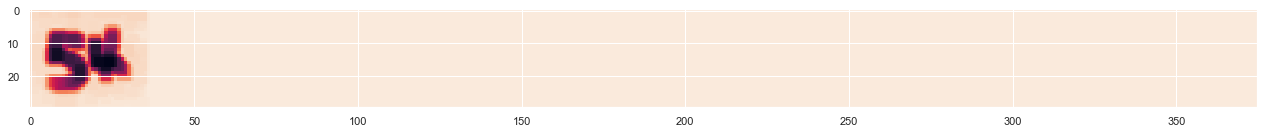

In [7]:
plt.imshow(data[1490])

## Data Processing

In [8]:
label = read_final_label('../src/Method 2_dataset/final_augment_handwritten.txt')

In [9]:
data, label = shuffle(data,label, random_state=42)

In [18]:
label = [i.replace('||',' ') for i in label]
label = [i.replace('|',' ') for i in label]
label = [i[1:] if i[0]==' ' else i for i in label]
label = [i[:-1] if i[-1]==' ' else i for i in label]
label = [i.replace('  ',' ') for i in label]
label = [i.replace('\n','') for i in label]

In [19]:
chars = string.printable[:95]

In [20]:
encoded_label = [encode_string(i,chars) for i in label]

In [23]:
maxv = 0
for i in encoded_label:
    if len(i) > maxv:
        maxv = len(i)

In [24]:

pad_label = copy.deepcopy(encoded_label)
for i in range(len(pad_label)):
    if len(pad_label[i])<maxv:
        diff = maxv - len(pad_label[i])
        for j in range(diff):
            pad_label[i].append(chars.find(' '))
       

In [25]:
maxv

58

### Train Test Split

In [82]:
valid_padded_txt = list()
train_padded_txt = list()
test_padded_txt = list()
# lists for training dataset
train_img = []
train_txt = []
train_input_length = []
train_label_length = []
train_orig_txt = []

#lists for test dataset
test_img = []
test_txt = []
test_input_length = []
test_label_length = []
test_orig_txt = []

#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
for i in range(len(data)):
    if i < 1500:
        valid_orig_txt.append(label[i])   
        valid_label_length.append(len(label[i]))
        valid_input_length.append(62)
        valid_img.append(data[i])
        valid_txt.append(encoded_label[i])
        valid_padded_txt.append(pad_label[i])
    
    elif i >= 1500 and i < 3000:
        test_orig_txt.append(label[i])   
        test_label_length.append(len(label[i]))
        test_input_length.append(62)
        test_img.append(data[i])
        test_txt.append(encoded_label[i])
        test_padded_txt.append(pad_label[i])
        
    else:
        train_orig_txt.append(label[i])   
        train_label_length.append(len(label[i]))
        train_input_length.append(62)
        train_img.append(data[i])
        train_txt.append(encoded_label[i])
        train_padded_txt.append(pad_label[i])

In [83]:
len(train_img)

12297

In [84]:
len(test_img)

1500

In [85]:
len(valid_img)

1500

In [86]:
len(valid_img) + len(test_img) + len(train_img)

15297

In [87]:
len(train_img)

12297

## LSTM model

In [88]:

init_mode='lecun_uniform'
inputs = Input(shape=(30,375,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu',padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu',padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu',padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu',padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

# conv_6 = Conv2D(512, (3,3), activation = 'relu',padding='same')(batch_norm_5)
# pool_6 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(conv_5)
batch_norm_6 = BatchNormalization()(conv_7)
pool_7 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
conv_8 = Conv2D(512, (3,3), activation = 'relu',padding='same')(pool_7)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_8)

# bidirectional LSTM layers with units=128
blstm_1 = LSTM(256, return_sequences=True, dropout = 0.3)(squeezed)
blstm_2 = LSTM(256, return_sequences=True, dropout = 0.3)(blstm_1)

outputs = Dense(len(chars)+1, activation = 'softmax')(blstm_2)

act_model = Model(inputs, outputs)

In [89]:
act_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30, 375, 1)]      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 375, 64)       640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 187, 64)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 187, 128)      73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 93, 128)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 93, 256)        295168    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 93, 256)        5900

In [90]:
labels = Input(name='the_labels', shape=[maxv], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

In [91]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

In [92]:
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [93]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10)

In [94]:
loss_history = History()
adam = Adam(learning_rate=0.0001,clipvalue=0.5,clipnorm=1.0)

In [95]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = adam)

In [96]:
filepath="models/best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tb = TensorBoard(histogram_freq=1,write_grads=True)
callbacks_list = [checkpoint,tb,loss_history,es]

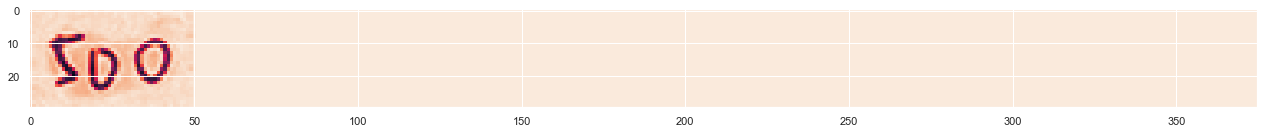

In [97]:
plt.imshow(valid_img[169])

In [98]:
valid_orig_txt[169]

'500'

In [99]:

training_img = np.array(train_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)
train_padded_txt = np.array(train_padded_txt)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)
valid_padded_txt = np.array(valid_padded_txt)

test_img = np.array(test_img)
test_input_length = np.array(test_input_length)
test_label_length = np.array(test_label_length)
test_padded_txt = np.array(test_padded_txt)

In [100]:
batch_size = 256
epochs = 200
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Epoch 1/200
49/49 [==============================] - 520s 11s/step - loss: 122.6457 - val_loss: 35.7443

Epoch 00001: val_loss improved from inf to 35.74426, saving model to models/best_model.hdf5
Epoch 2/200
49/49 [==============================] - 544s 11s/step - loss: 32.2775 - val_loss: 32.2096

Epoch 00002: val_loss improved from 35.74426 to 32.20959, saving model to models/best_model.hdf5
Epoch 3/200
49/49 [==============================] - 548s 11s/step - loss: 28.9407 - val_loss: 30.3133

Epoch 00003: val_loss improved from 32.20959 to 30.31331, saving model to models/best_model.hdf5
Epoch 4/200
49/49 [==============================] - 617s 13s/step - loss: 28.5078 - val_loss: 38.2137

Epoch 00004: val_loss did not improve from 30.31331
Epoch 5/200
49/49 [==============================] - 735s 15s/step - loss: 27.8363 - val_loss: 32.9128

Epoch 00005: val_loss did not improve from 30.31331
Epoch 6/200
49/49 [==============================] - 631s 13s/step - loss: 26.7544 - val_


Epoch 00045: val_loss did not improve from 14.72259
Epoch 46/200
49/49 [==============================] - 711s 15s/step - loss: 12.5972 - val_loss: 14.1004

Epoch 00046: val_loss improved from 14.72259 to 14.10044, saving model to models/best_model.hdf5
Epoch 47/200
49/49 [==============================] - 550s 11s/step - loss: 12.3219 - val_loss: 16.5013

Epoch 00047: val_loss did not improve from 14.10044
Epoch 48/200
49/49 [==============================] - 545s 11s/step - loss: 11.8229 - val_loss: 14.0566

Epoch 00048: val_loss improved from 14.10044 to 14.05658, saving model to models/best_model.hdf5
Epoch 49/200
49/49 [==============================] - 676s 14s/step - loss: 11.7123 - val_loss: 13.4764

Epoch 00049: val_loss improved from 14.05658 to 13.47645, saving model to models/best_model.hdf5
Epoch 50/200
49/49 [==============================] - 700s 14s/step - loss: 11.4699 - val_loss: 13.7519

Epoch 00050: val_loss did not improve from 13.47645
Epoch 51/200
49/49 [=======

Epoch 140/200
49/49 [==============================] - 542s 11s/step - loss: 0.9598 - val_loss: 4.4218

Epoch 00140: val_loss improved from 4.60471 to 4.42181, saving model to models/best_model.hdf5
Epoch 141/200
49/49 [==============================] - 543s 11s/step - loss: 1.0201 - val_loss: 4.2584

Epoch 00141: val_loss improved from 4.42181 to 4.25841, saving model to models/best_model.hdf5
Epoch 142/200
49/49 [==============================] - 542s 11s/step - loss: 0.8996 - val_loss: 4.7649

Epoch 00142: val_loss did not improve from 4.25841
Epoch 143/200
49/49 [==============================] - 573s 12s/step - loss: 0.9414 - val_loss: 4.4480

Epoch 00143: val_loss did not improve from 4.25841
Epoch 144/200
49/49 [==============================] - 719s 15s/step - loss: 0.8823 - val_loss: 4.7409

Epoch 00144: val_loss did not improve from 4.25841
Epoch 145/200
49/49 [==============================] - 727s 15s/step - loss: 0.8743 - val_loss: 4.6043

Epoch 00145: val_loss did not imp

In [1]:
%load_ext tensorboard

In [3]:
%tensorboard --logdir runs_pytorch_rec/modelA/

In [21]:
1*24*60*60+0*60*60+12*60+28

87148

In [32]:
act_model.load_weights('models/best_model.hdf5')
prediction = act_model.predict(test_img)
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

NameError: name 'act_model' is not defined

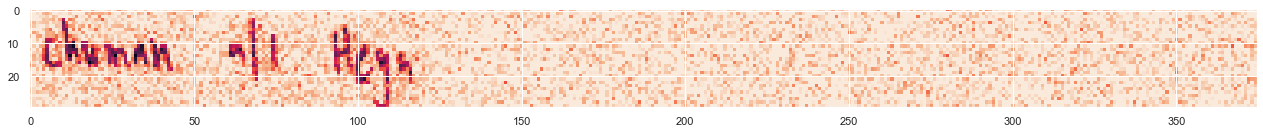

In [104]:
plt.imshow(test_img[1])

In [105]:
j=0
for item in out:

    print('Predicted: ',end='')
    for i in item:
        if i != -1:
            print(chars[int(i)], end = '')
    
    print('\nOriginal: '+test_orig_txt[j])
    j+=1
    print('\n')



Predicted: -
Original: -


Predicted: chuman a/1 Heya
Original: chuman a/l Heya


Predicted: 18-3-2020
Original: 18-3-2020


Predicted: 600
Original: 600


Predicted: 15
Original: 15


Predicted: 13/2/2020
Original: 13/2/2020


Predicted: wwoo. hospital.com
Original: www.hospital.com


Predicted: 30th June 2018
Original: 30th June 2018


Predicted: 90
Original: 90


Predicted: -
Original: 350


Predicted: -
Original: -


Predicted: X-Ray
Original: X-Ray


Predicted: 7 April219
Original: 7th April 2019


Predicted: Isotretinoin
Original: Isotretinoin


Predicted: 1600
Original: 1600


Predicted: 32
Original: 32


Predicted: 6th Jun 2013
Original: 6th Jun 2018


Predicted: 100
Original: 100


Predicted: RM a5 
Original: 10th May 2020


Predicted: 600
Original: 600$


Predicted: 30
Original: 30


Predicted: 50
Original: 50


Predicted: 100
Original: 100


Predicted: 14/3/2019
Original: 14/3/2019


Predicted: AH83
Original: AH83


Predicted: Bei Er
Original: Bei Er


Predicted: 6th May 201

Predicted: Xaier Clinic
Original: Xavier Clinic


Predicted: 95,Jalan 20,Taman A
Original: 95,Jalan 20,Taman A


Predicted: 2/2020
Original: 2/7/2020


Predicted: 1
Original: 1


Predicted: Dr. Tan Wu Lai
Original: Dr. Tan Wu Lai


Predicted: 014-7328930
Original: 014-7328930


Predicted: Abu
Original: Abu


Predicted: 0
Original: 0


Predicted: 4/10/2020
Original: 4/10/2020


Predicted: 20
Original: 20


Predicted: 9/3/2013
Original: 9/3/2013


Predicted: Chai Amne
Original: Chai Anne


Predicted: Wong
Original: Wong


Predicted: Emily Clinic
Original: Emily Clinic


Predicted: 220t June 2018
Original: 30th June 2018


Predicted: 50g
Original: 50g


Predicted: Consultaton Medicines
Original: Consultation, Medicines


Predicted: 18
Original: 18


Predicted: 1
Original: 1


Predicted: Lim Chin Mian
Original: Lim Chin Min


Predicted: -
Original: -


Predicted: Chu Li Wen
Original: Chu Li Wen


Predicted: 3406
Original: 3426


Predicted: Safie Bin Amrirul
Original: Safie Bin Amirul


Pre

Predicted: 12.12.2020
Original: 12.12.2020


Predicted: Ganesh A/L Ali
Original: Ganesh A/L Ali


Predicted: Chong Ya Zhu
Original: Chong Ya Zhu


Predicted: 9/11/2020
Original: 9/11/2020


Predicted: 7, Jalan Perjiranan 12, Bandar Drto Onn.cm.
Original: 7, Jalan Perjiranan 12, Bandar Dato Onn.


Predicted: 3/2/20
Original: 3/2/20


Predicted: -
Original: -


Predicted: Calcium
Original: Calcium


Predicted: 02-7718600
Original: 012-7718600


Predicted: JA013
Original: JA013


Predicted: 10600
Original: 105.00


Predicted: Hur zitti
Original: Nur Siti


Predicted: -
Original: -


Predicted: -
Original: -


Predicted: Antibiotic
Original: Antibiotic


Predicted: four hundred
Original: four hundred


Predicted: 018-3283171
Original: 018-3283171


Predicted: 30
Original: 1


Predicted: Fifty-five
Original: Fifty-five


Predicted: 100
Original: 100


Predicted: 63
Original: 63


Predicted: 101
Original: 101


Predicted: X-R0200
Original: 86200


Predicted: consultation and medicine
Origina

Predicted: 13, Jalan 8,
Original: 13, Jalan 8,


Predicted: 2
Original: 2


Predicted: 10
Original: 10


Predicted: 3/1/2020
Original: 3/1/2020


Predicted: RM75
Original: RM75


Predicted: 90
Original: 90


Predicted: 60
Original: 60


Predicted: 88.95
Original: 88.95


Predicted: 7540, Ayer Keroh
Original: 75450, Ayer Keroh


Predicted: 7,Jalan Rakr, Puat Perdagangan Baki,8400 Moar Joho.o.plar, Johor.
Original: 7,Jalan Rakir, Pusat Perdagangan Bakri,84000 Muar,Johor.


Predicted: -
Original: -


Predicted: 138
Original: 138


Predicted: 48500, Semengih, Selangor
Original: 43500, Semenyih, Selangor


Predicted: 32.5,Jalan Arab,
Original: 32-5,Jalan Arab,


Predicted: 12/9/20020
Original: 12/9/2020


Predicted: 20
Original: 20


Predicted: Mohamad Ali
Original: Mohamad Ali


Predicted: 11/12/2017
Original: 11/12/2017


Predicted: Lim Jia Jun
Original: Lim Jia Jun


Predicted: -
Original: -


Predicted: 250
Original: 250


Predicted: 3
Original: 3


Predicted: -
Original: -


Predicted:

Predicted: Tey Zhi
Original: Tey Zhi


Predicted: 5, Jalan Hao, Taman
Original: 5, Jalan Hao, Taman


Predicted: Dr.Tan
Original: Dr.Tan


Predicted: Cash
Original: cash


Predicted: Alex
Original: Alex


Predicted: consultation.
Original: consultation.


Predicted: 20.50
Original: 20.50


Predicted: 5C
Original: Jack Clinic


Predicted: -
Original: -


Predicted: A04359
Original: A04359


Predicted: No 5, Jalan Pekanas.
Original: No 5, Jalan Pekanas.


Predicted: consultation + Medicines
Original: consultation + Medicines


Predicted: -
Original: -


Predicted: -
Original: -


Predicted: 054 50
Original: 454.50


Predicted: 50a
Original: 50G


Predicted: 86200
Original: 86200


Predicted: Ali
Original: Ali


Predicted: 3/10/2020
Original: 3/10/2020


Predicted: medicines
Original: medicines


Predicted: 1
Original: 1%


Predicted: 25
Original: 25$


Predicted: A01
Original: A01


Predicted: -
Original: -


Predicted: Cash
Original: Cash


Predicted: Saylen
Original: Jayden


Predicted

In [106]:
def decode(output,chars):
    decoded_txt = []
    for item in output:
        curr_list = ''
        for i in item:
            if i != -1:
                curr_list+=chars[int(i)]
        decoded_txt.append(str(curr_list))
    return decoded_txt

In [107]:
output_txt = decode(out,chars)

In [114]:
fastwer.score(output_txt, test_orig_txt, char_level=True)


11.5503

In [115]:
fastwer.score(output_txt, test_orig_txt)

26.6393

In [108]:
test_orig_txt[0]

'-'

In [109]:
output_lower = [a.lower() for a in output_txt]
# output_lower = [i[1:] if i[0]==' ' else i for i in output_lower]
# output_lower = [i[:-1] if i[-1]==' ' else i for i in output_lower]
output_lower = [i.replace(', ',',') for i in output_lower]
output_lower = [i.replace(' ,',',') for i in output_lower]
output_lower = [i.replace(' , ',',') for i in output_lower]
output_lower = [i.replace('- ','-') for i in output_lower]
output_lower = [i.replace(' -','-') for i in output_lower]
output_lower = [i.replace(' - ','-') for i in output_lower]


In [110]:
test_lower = [a.lower() for a in test_orig_txt]

test_lower = [i.replace(', ',',') for i in test_lower]
test_lower = [i.replace(' ,',',') for i in test_lower]
test_lower = [i.replace(' , ',',') for i in test_lower]
test_lower = [i.replace('- ','-') for i in test_lower]
test_lower = [i.replace(' -','-') for i in test_lower]
test_lower = [i.replace(' - ','-') for i in test_lower]


In [111]:
import fastwer

In [112]:


fastwer.score(test_lower, output_lower, char_level=True)

11.409

In [113]:
fastwer.score(test_lower, output_lower)

25.6925

## Match with Dict

In [249]:
def read_dict(file):

    f = open(file,"r")
    full_label = list()
    for line in f:
        full_label.append(line[:-1])


    return full_label

In [250]:
unique_dict = read_dict('datadict.txt')

In [251]:
from nltk.metrics import edit_distance

In [252]:
corrected_output_txt = list()

for a in output_txt:
    string = ''
    min_val = 100
    a = a.split(' ')
    for item in a:
        if item not in unique_dict:
            for j in unique_dict:
                val = edit_distance(item,j)
                if val < min_val:
                    min_val = val
                    chosen_string = j
            string+=chosen_string+' '
        elif string !=' ':
            string+=item+' '
    corrected_output_txt.append(string)

In [253]:
corrected_output_txt = [i.replace('  ','') for i in corrected_output_txt]

In [257]:
corrected_output_txt = [i[:-1] if i[-1]==' ' else i for i in corrected_output_txt]

In [258]:
corrected_output_txt[50]

'Address: JLN JLN Cheng'

In [279]:
fastwer.score(test_orig_txt, output_txt)

9.297

In [280]:
fastwer.score(test_orig_txt, output_txt, char_level=True)

6.1228